# <center> Задача по идентификации пользователя с именем Alice. https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/overview  

Цель проекта - определить по последовательности нескольких веб-сайтов, Alice посещала их или кто-то другой.  
Задачи проекта:  
- проанализировать исходные данные;
- предобработать исходные данные;
- построить алгоритм, который будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком.

In [1]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import scipy.sparse as sp
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from scipy.stats import ttest_rel
from sklearn.preprocessing import MinMaxScaler 
from sklearn.feature_selection import SelectFromModel

In [2]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Для начала загрузим исходные данные и визуально проанализируем их:

In [3]:
times = ['time%d' % i for i in range(1, 11)]
train_df = pd.read_csv('train_sessions.csv', index_col='session_id', parse_dates = times)
test_df = pd.read_csv('test_sessions.csv', index_col='session_id', parse_dates = times)

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  date

В обучающей выборке видим следующие признаки:

- site1 – индекс первого посещенного сайта в сессии
- time1 – время посещения первого сайта в сессии
- ...
- site10 – индекс 10-го посещенного сайта в сессии
- time10 – время посещения 10-го сайта в сессии
- user_id – ID пользователя
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут.

In [6]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Alice. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно. Поэтому в качестве метрики будем использовать ROC-AUC

Объединим тестовую и обучающую выборки и приведем их к разреженному виду:

In [7]:
train_test_df = pd.concat([train_df, test_df])
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [8]:
def matrix(d):
    X = d.values
    indptr = [0]
    indices = []
    data = []
    site = {}
    for x in X:
        for term in x:
            index = site.setdefault(term, term)
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    return csr_matrix((data, indices, indptr), dtype=int)[:,1:]

In [9]:
train_test_sparse = (matrix(train_test_df_sites))
X_train_sparse = train_test_sparse[:train_df.shape[0],:]
X_test_sparse = train_test_sparse[train_df.shape[0]:,:]
y = train_df['target']

Из исходных данных обучающей выборки веделим новые признаки: количество уникальных сайтов в выборке, день недели, час, месяц и год час начала выборки, а также длительность сессии; и посмотрим как они распределены для Alice и остальных.

In [10]:
def prepare_set_with_fe(X, y = 0):
    df = pd.DataFrame()
    sites = X[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
    sites = sites.values
    df['num_unique'] = [len(np.unique(sites[i]))-1 if 0 in np.unique(sites[i])
                        else len(np.unique(sites[i])) for i in range(len(sites))]
    df['day_of_week'] = X['time1'].reset_index(drop = True).dt.dayofweek
    df['hour'] = X['time1'].reset_index(drop = True).dt.hour
    df['day'] = X['time1'].reset_index(drop = True).dt.day
    df['month'] = X['time1'].reset_index(drop = True).dt.month
    df['year'] = X['time1'].reset_index(drop = True).dt.year
    df['dayofyear'] = X['time1'].reset_index(drop = True).dt.dayofyear
    duration = []
    for k in range(1, X.shape[0]+1):
        for i in range(10, 0, -1):
            if X['time'+str(i)][k] == X['time'+str(i)][k]:
                duration.append(X['time%d' % i][k] - X['time1'][k])
                break
    df['duration'] = duration
    df['duration'] = df['duration'].dt.total_seconds().astype('int')
    if type(y) != int:
        df['target'] = y.reset_index(drop = True)
    return df

In [11]:
train_new_features = prepare_set_with_fe(train_df, y)

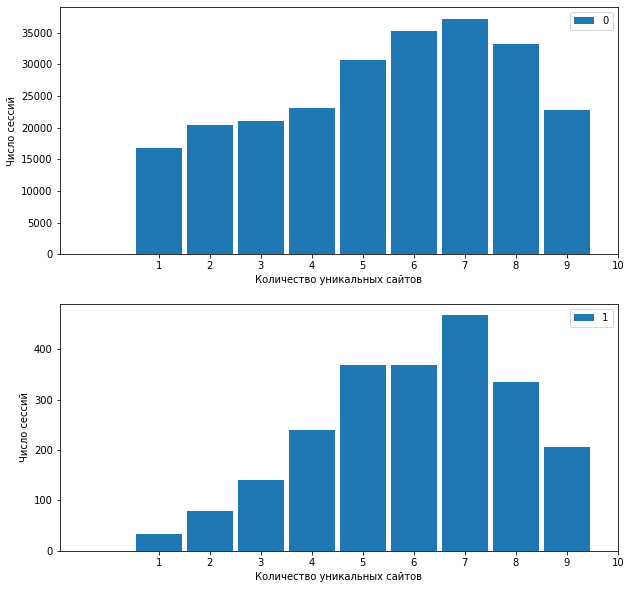

In [12]:
fig, axes = plt.subplots(2, figsize=(10, 10))

for idx, (user, sub_df) in  enumerate(train_new_features.groupby(train_new_features['target'])): 
    axes[idx].hist(sub_df['num_unique'],bins = 10, range=(-0.5,9.5), align='mid', rwidth = 0.9)
    axes[idx].legend([user])
    axes[idx].set_xlabel('Количество уникальных сайтов')
    axes[idx].set_ylabel('Число сессий')
    axes[idx].set_xticks(range(1, 11))

И Alice, и остальные пользователи чаще посещают по семь различных сайтов за сессию.

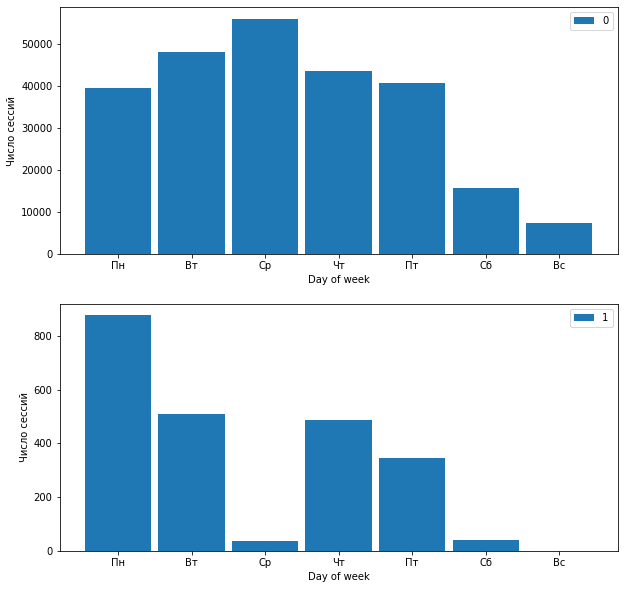

In [13]:
fig, axes = plt.subplots(2, figsize=(10, 10))

for idx, (user, sub_df) in  enumerate(train_new_features.groupby(train_new_features['target'])): 
    axes[idx].hist(sub_df['day_of_week'], bins = 7, range=(-0.5,6.5), align='mid', rwidth = 0.9)
    axes[idx].legend([user])
    axes[idx].set_xlabel('Day of week')
    axes[idx].set_ylabel('Число сессий')
    axes[idx].set_xticks(range(7))
    axes[idx].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])


Alice чаще пользуется интернетом по понедельникам и совсем не заходит в воскресенье. В тоже время остальные пользователи чаще сидят в интернете по средам.

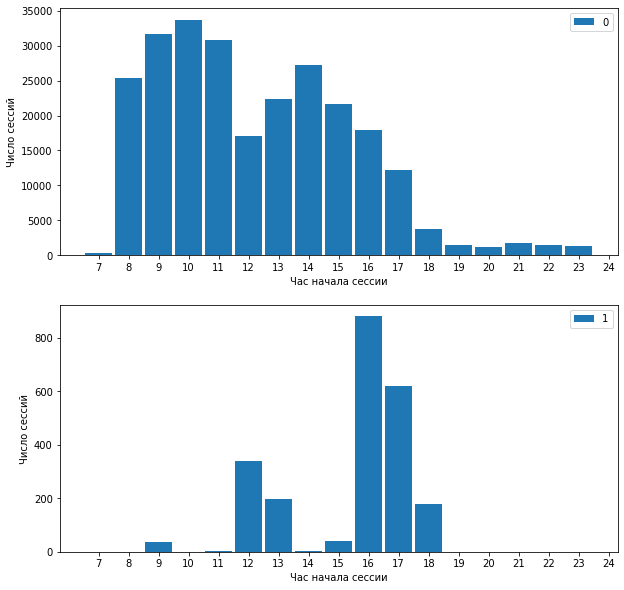

In [14]:
fig, axes = plt.subplots(2, figsize=(10, 10))

for idx, (user, sub_df) in  enumerate(train_new_features.groupby(train_new_features['target'])): 
    axes[idx].hist(sub_df['hour'],bins = 17, range=(6.5,23.5), align='mid', rwidth = 0.9)
    axes[idx].legend([user])
    axes[idx].set_xlabel('Час начала сессии')
    axes[idx].set_ylabel('Число сессий')
    axes[idx].set_xticks(range(7, 25))

Alice чаще всего сидит в интернете в промежуток от 16 до 18 часов, и совесм не использует интренет после 19. Остальные пользователи заходят в интернет чаще с 9 до 12 часов

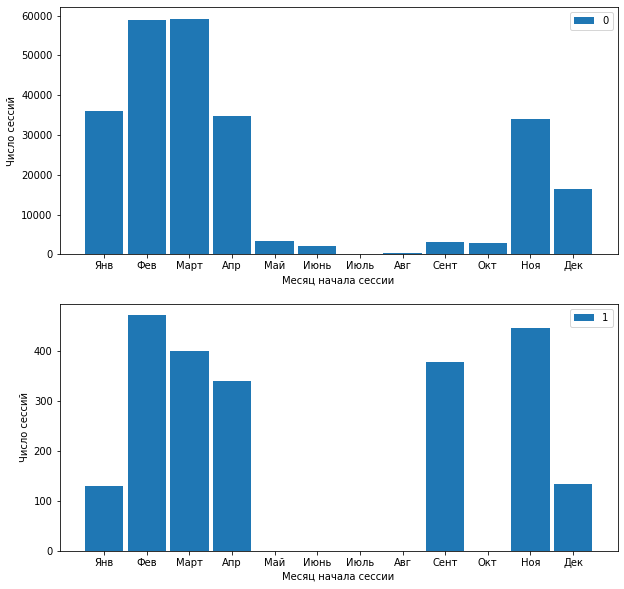

In [15]:
fig, axes = plt.subplots(2, figsize=(10, 10))

for idx, (user, sub_df) in  enumerate(train_new_features.groupby(train_new_features['target'])): 
    axes[idx].hist(sub_df['month'],bins = 12, range=(0.5,12.5), align='mid', rwidth = 0.9)
    axes[idx].legend([user])
    axes[idx].set_xlabel('Месяц начала сессии')
    axes[idx].set_ylabel('Число сессий')
    axes[idx].set_xticks(range(1, 13))
    axes[idx].set_xticklabels(['Янв', 'Фев', 'Март', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сент', \
                               'Окт', 'Ноя', 'Дек'])

Alice чаще всего сидела в интернете в феврале и ноябре, совсем не заходила летом и в мае. Остальные пользователи чаще посещали интернет в феврале и марте, совсем не посещали в июле.

Добавим новые признаки к тестовой выборке и объединим ее с обучающей

In [16]:
test_new_features = prepare_set_with_fe(test_df)

In [17]:
train_test_df_new_features = pd.concat([train_new_features.drop(['target'],  axis='columns'), test_new_features])
train_test_df_new_features = train_test_df_new_features.reset_index(drop = True)

In [18]:
def hour(df):
    df_sparse = pd.DataFrame()
    hour = df['hour']
    df_sparse['morning'] = ((hour >= 7) & (hour <= 11)).astype(int)
    df_sparse['afternoon'] = ((hour >= 12) & (hour <= 18)).astype(int)
    df_sparse['evening'] = ((hour >= 19) & (hour <= 23)).astype(int)
    df_sparse['nigth'] = ((hour >= 0) | (hour <= 6)).astype(int)
    return df_sparse

In [19]:
hour_X = hour(train_test_df_new_features)

In [20]:
train_test_df_new_features

,num_unique,day_of_week,hour,day,month,year,dayofyear,duration
0,1,3,10,20,2,2014,51,0
1,7,5,11,22,2,2014,53,26
2,4,0,16,16,12,2013,350,7
3,1,4,10,28,3,2014,87,270
4,4,4,10,28,2,2014,59,246
...,...,...,...,...,...,...,...,...
336353,3,3,18,2,10,2014,275,0
336354,6,0,14,26,5,2014,146,39
336355,10,4,11,2,5,2014,122,8
336356,7,5,10,3,5,2014,123,13


In [21]:
matrix = csr_matrix(sp.hstack([train_test_sparse, hour_X,\
                                           train_test_df_new_features.drop('hour', axis = 1)]))
X_train_sparse = matrix[:train_df.shape[0],:]
X_test_sparse = matrix[train_df.shape[0]:,:]
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid = X_train_sparse[train_share:, :], y[train_share:]

Так как стоит задача бинарной классификации, то будем использовать логистическую регрессию для построения модели.
Сделаем такой бейзлайн и посмотрим на результаты кросс-валидации:

In [22]:
time_split = TimeSeriesSplit(n_splits = 5)
logit = LogisticRegression(random_state = 17, n_jobs = -1, solver = 'liblinear')
cross_val_score(estimator = logit, X = X_train, y = y_train, cv = time_split, scoring = 'roc_auc').mean()

0.9682906836127387

Сравним результаты кросс-валидации логистической регрессии с SGDClassifier с логистической функцией потерь. И проверим статистически ли значима разница в результатах двух классификаторов. Для этого будем использовать t-критерий Стьюдента.

In [23]:
logit_scores = cross_val_score(estimator = logit, X = X_train, y = y_train, cv = time_split, scoring = 'roc_auc')
sgd = SGDClassifier(loss = 'log', random_state = 17, n_jobs = -1)
sgd_scores = cross_val_score(estimator = sgd, X = X_train, y = y_train, cv = time_split, scoring = 'roc_auc')
ttest_rel(logit_scores, sgd_scores) 

Ttest_relResult(statistic=6.257430892256816, pvalue=0.003326733407269294)

Так как статистика положительна, то делаем вывод, что логистическая регрессия показывает результаты выше, чем SGDClassifier с логистической функцией потерь. А так как p-value ниже 0,05, то можно отвергнуть нулевую гипотезу о том, что обе модели дают одинаковый результат.  
Поэтому дальше будем делать пользоваться алгоритмом логистической регрессии.

Попробуем из признаков оставить только сайты и проверим улучшили ли новые признаки модель:

In [24]:
matrix_only_sites = csr_matrix(sp.hstack([train_test_sparse]))
X_train_sparse_only_sites= matrix_only_sites[:train_df.shape[0],:]
X_test_sparse_only_sites = matrix_only_sites[train_df.shape[0]:,:]
X_train_only_sites = X_train_sparse_only_sites[:train_share, :]
X_valid_only_sites = X_train_sparse_only_sites[train_share:, :]

In [25]:
logit_scores_only_sites = cross_val_score(estimator = logit, X = X_train_only_sites, \
                               y = y_train, cv = time_split, scoring = 'roc_auc')
ttest_rel(logit_scores, logit_scores_only_sites)

Ttest_relResult(statistic=5.590016920216662, pvalue=0.005024496111379353)

Добавление признаков приводит к статистически значимому улучшению модели.

Проверим какие веса дают новые признаки:

In [26]:
logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=17,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [27]:
new_feature_names = ['morning', 'afternoon', 'evening', 'nigth', 'num_unique', \
                     'day_of_week', 'day', 'month', 'year', 'dayofyear','duration']

In [28]:
print('New feature weights:')
    
print(pd.DataFrame({'feature': new_feature_names, 
                    'coef': logit.coef_.flatten()[-len(new_feature_names):]}))
    

New feature weights:
        feature      coef
0       morning -1.700261
1     afternoon  2.264724
2       evening -0.562831
3         nigth  0.001633
4    num_unique  0.214535
5   day_of_week -0.345982
6           day -0.030968
7         month -0.015280
8          year -0.004254
9     dayofyear  0.004428
10     duration -0.000658


Признаки year, dayofyear и duration нужно отнормировать.

In [29]:
scaler_day = MinMaxScaler()
dayofyear_train = scaler_day.fit_transform(pd.DataFrame(train_new_features['dayofyear']))
dayofyear_test = scaler_day.transform(pd.DataFrame(test_new_features['dayofyear']))
dayofyear_X = np.append(dayofyear_train, dayofyear_test)

In [30]:
scaler_duration = MinMaxScaler()
duration_train = scaler_duration.fit_transform(pd.DataFrame(train_new_features['duration']))
duration_test = scaler_duration.transform(pd.DataFrame(test_new_features['duration']))
duration_X = np.append(duration_train, duration_test)

In [31]:
train_test_df_new_features['year'] = train_test_df_new_features.year.map(lambda y: y-2013)

In [32]:
train_test_df_new_features['dayofyear'] = dayofyear_X 
train_test_df_new_features['duration'] = duration_X 
train_test_df_new_features

,num_unique,day_of_week,hour,day,month,year,dayofyear,duration
0,1,3,10,20,2,1,0.134986,0.000000
1,7,5,11,22,2,1,0.140496,0.014444
2,4,0,16,16,12,0,0.958678,0.003889
3,1,4,10,28,3,1,0.234160,0.150000
4,4,4,10,28,2,1,0.157025,0.136667
...,...,...,...,...,...,...,...,...
336353,3,3,18,2,10,1,0.752066,0.000000
336354,6,0,14,26,5,1,0.396694,0.021667
336355,10,4,11,2,5,1,0.330579,0.004444
336356,7,5,10,3,5,1,0.333333,0.007222


Проверим какие теперь будут веса:

In [33]:
matrix = csr_matrix(sp.hstack([train_test_sparse, hour_X,\
                                           train_test_df_new_features.drop('hour', axis = 1)]))
X_train_sparse = matrix[:train_df.shape[0],:]
X_test_sparse = matrix[train_df.shape[0]:,:]
X_train = X_train_sparse[:train_share, :]
X_valid = X_train_sparse[train_share:, :]

In [34]:
logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=17,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [35]:
print('New feature weights:')
    
print(pd.DataFrame({'feature': new_feature_names, 
                    'coef': logit.coef_.flatten()[-len(new_feature_names):]}))

New feature weights:
        feature      coef
0       morning -3.009855
1     afternoon  1.242178
2       evening -2.262153
3         nigth -4.029830
4    num_unique  0.252430
5   day_of_week -0.424943
6           day -0.029763
7         month  0.018079
8          year -0.930416
9     dayofyear  0.432381
10     duration -0.849562


Теперь все выглядит значительно лучше.

In [36]:
logit_scores_scaled = cross_val_score(estimator = logit, X = X_train, \
                               y = y_train, cv = time_split, scoring = 'roc_auc')
ttest_rel(logit_scores, logit_scores_scaled)

Ttest_relResult(statistic=-2.2293789729528903, pvalue=0.08967273764553024)

Нормирование улучшило модель.

Попробуем добавить еще признак, объединив год и месяц

In [37]:
def month_year_add(row):
    return int(row.month+12) if row.year == 1 else int(row.month)
train_test_df_new_features['month_year'] = train_test_df_new_features.apply(month_year_add, axis = 'columns')

In [38]:
matrix_with_monthyear = csr_matrix(sp.hstack([train_test_sparse, hour_X,\
                                           train_test_df_new_features.drop('hour', axis = 1)]))
X_train_sparse_with_monthyear = matrix_with_monthyear[:train_df.shape[0],:]
X_test_sparse_with_monthyear = matrix_with_monthyear[train_df.shape[0]:,:]
X_train_with_monthyear = X_train_sparse_with_monthyear[:train_share, :]
X_valid_with_monthyear = X_train_sparse_with_monthyear[train_share:, :]

In [39]:
logit_scores_with_monthyear = cross_val_score(estimator = logit, X = X_train_with_monthyear, \
                               y = y_train, cv = time_split, scoring = 'roc_auc')
ttest_rel(logit_scores_scaled, logit_scores_with_monthyear)

Ttest_relResult(statistic=0.3692606258730584, pvalue=0.7306500441457238)

Добавление признака не привело к улучшению модели. Этого и следовало ожидать, так как он коррелирован и двумя признаками, на которых он основан. Посмотрим матрицу корреляции:

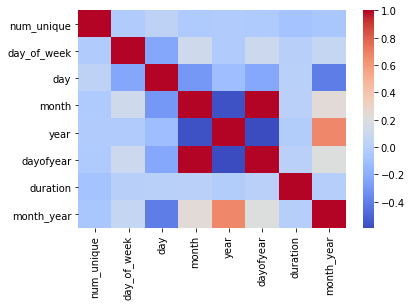

In [40]:
sns.heatmap(train_test_df_new_features.drop('hour', axis = 1).corr(), cmap= 'coolwarm')

Помимо уже упомянутых коррелированных признаков есть и другие: dayofyear & month, dayofyeat & year, year & month, month_year & day, month_year & year.  
Попробуем убрать следующие признаки year, month, day.

In [41]:
matrix_deleted_features = csr_matrix(sp.hstack([train_test_sparse, hour_X,\
                                    train_test_df_new_features.drop(['hour', 'year', 'month', 'day'], axis = 1)]))
X_train_sparse_deleted_features = matrix_deleted_features[:train_df.shape[0],:]
X_test_sparse_deleted_features = matrix_deleted_features[train_df.shape[0]:,:]
X_train_deleted_features = X_train_sparse_deleted_features[:train_share, :]
X_valid_deleted_features = X_train_sparse_deleted_features[train_share:, :]

In [42]:
logit_scores_deleted_features = cross_val_score(estimator = logit, X = X_train_deleted_features, \
                               y = y_train, cv = time_split, scoring = 'roc_auc')
ttest_rel(logit_scores_scaled, logit_scores_deleted_features)

Ttest_relResult(statistic=3.1550924251699675, pvalue=0.034345523185834746)

In [43]:
logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse, y)
logit_test_pred_proba = logit.predict_proba(X_test_sparse)
write_to_submission_file(logit_test_pred_proba.T[1], 'Submission')

0.93748

Попробуем отобрать необходимые с помощью l1 регуляризации:

In [44]:
all_features = pd.concat([train_test_df_new_features.drop('hour', axis = 1), hour_X], axis = 1)
train_features = all_features.iloc[:train_df.shape[0],:]

In [45]:
%%time
logistic = LogisticRegression(C=1, penalty="l1", solver='liblinear', \
                              random_state=17).fit(train_features, y)
model = SelectFromModel(logistic, prefit=True)
X_new = model.transform(train_features)
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=train_features.index,
                                 columns=train_features.columns)
selected_columns = selected_features.columns[selected_features.var() != 0]

CPU times: user 35.7 s, sys: 59.9 ms, total: 35.8 s
Wall time: 35.8 s


In [46]:
selected_columns

Index(['num_unique', 'day_of_week', 'day', 'month', 'duration', 'month_year',
       'morning', 'evening'],
      dtype='object')

При таком отборе признаков удаляются 'year', 'dayofyear', 'afternoon'. Проверим дает ли это улучшение метрики

In [47]:
train_test_df_final = pd.concat([hour_X, train_test_df_new_features.drop('hour', axis = 1)], axis = 1)
matrix_selected = csr_matrix(sp.hstack([train_test_sparse, train_test_df_final]))
X_train_sparse_selected = matrix_selected[:train_df.shape[0],:]
X_test_sparse_selected = matrix_selected[train_df.shape[0]:,:]
X_train_selected = X_train_sparse_selected[:train_share, :]
X_valid_selected = X_train_sparse_selected[train_share:, :]

In [48]:
logit_scores_selected = cross_val_score(estimator = logit, X = X_train_selected, \
                               y = y_train, cv = time_split, scoring = 'roc_auc')
ttest_rel(logit_scores_scaled, logit_scores_selected)

Ttest_relResult(statistic=0.3692606258730584, pvalue=0.7306500441457238)

In [49]:
logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse_selected, y)
logit_test_pred_proba = logit.predict_proba(X_test_sparse_selected)
write_to_submission_file(logit_test_pred_proba.T[1], 'Submission')

0.94084

In [50]:
train_test_df_final

,morning,afternoon,evening,nigth,num_unique,day_of_week,day,month,year,dayofyear,duration,month_year
0,1,0,0,1,1,3,20,2,1,0.134986,0.000000,14
1,1,0,0,1,7,5,22,2,1,0.140496,0.014444,14
2,0,1,0,1,4,0,16,12,0,0.958678,0.003889,12
3,1,0,0,1,1,4,28,3,1,0.234160,0.150000,15
4,1,0,0,1,4,4,28,2,1,0.157025,0.136667,14
...,...,...,...,...,...,...,...,...,...,...,...,...
336353,0,1,0,1,3,3,2,10,1,0.752066,0.000000,22
336354,0,1,0,1,6,0,26,5,1,0.396694,0.021667,17
336355,1,0,0,1,10,4,2,5,1,0.330579,0.004444,17
336356,1,0,0,1,7,5,3,5,1,0.333333,0.007222,17


In [51]:
matrix_from_kaggle = csr_matrix(sp.hstack([train_test_sparse, \
                     train_test_df_final.drop(['num_unique', 'day', 'year', 'dayofyear'], axis = 1)]))
X_train_sparse_from_kaggle= matrix_from_kaggle[:train_df.shape[0],:]
X_test_sparse_from_kaggle = matrix_from_kaggle[train_df.shape[0]:,:]
X_train_from_kaggle = X_train_sparse_from_kaggle[:train_share, :]
X_valid_from_kaggle = X_train_sparse_from_kaggle[train_share:, :]

In [52]:
logit_scores_from_kaggle = cross_val_score(estimator = logit, X = X_train_from_kaggle, \
                               y = y_train, cv = time_split, scoring = 'roc_auc')
ttest_rel(logit_scores_scaled, logit_scores_from_kaggle)

Ttest_relResult(statistic=-0.8756397531771705, pvalue=0.4306590748903515)

In [53]:
logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse_from_kaggle, y)
logit_test_pred_proba = logit.predict_proba(X_test_sparse_from_kaggle)
write_to_submission_file(logit_test_pred_proba.T[1], 'Submission')

In [54]:
train_test_df_final.drop(['num_unique', 'day', 'year', 'dayofyear'], axis = 1).describe()

,morning,afternoon,evening,nigth,day_of_week,month,duration,month_year
count,336358.000000,336358.000000,336358.000000,336358.0,336358.000000,336358.000000,336358.000000,336358.000000
mean,0.474025,0.497705,0.028270,1.0,2.455616,5.377720,0.076334,14.713594
std,0.499326,0.499995,0.165745,0.0,1.722589,3.804095,0.162893,4.220533
min,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,1.0,1.000000,2.000000,0.003889,13.000000
50%,0.000000,0.000000,0.000000,1.0,2.000000,4.000000,0.015556,15.000000
75%,1.000000,1.000000,0.000000,1.0,4.000000,10.000000,0.062222,16.000000
max,1.000000,1.000000,1.000000,1.0,6.000000,12.000000,1.000000,24.000000


0.94501

In [55]:
matrix_from_kaggle2 = csr_matrix(sp.hstack([train_test_sparse, \
                     train_test_df_final.drop(['num_unique', 'day', 'year'], axis = 1)]))
X_train_sparse_from_kaggle2= matrix_from_kaggle2[:train_df.shape[0],:]
X_test_sparse_from_kaggle2 = matrix_from_kaggle2[train_df.shape[0]:,:]
X_train_from_kaggle2 = X_train_sparse_from_kaggle2[:train_share, :]
X_valid_from_kaggle2 = X_train_sparse_from_kaggle2[train_share:, :]

In [56]:
logit_scores_from_kaggle2 = cross_val_score(estimator = logit, X = X_train_from_kaggle2, \
                               y = y_train, cv = time_split, scoring = 'roc_auc')
ttest_rel(logit_scores_from_kaggle, logit_scores_from_kaggle2)

Ttest_relResult(statistic=-3.4928955455506716, pvalue=0.025056958103477685)

In [57]:
logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse_from_kaggle2, y)
logit_test_pred_proba = logit.predict_proba(X_test_sparse_from_kaggle2)
write_to_submission_file(logit_test_pred_proba.T[1], 'Submission')

0.94437

In [58]:
matrix_from_kaggle3 = csr_matrix(sp.hstack([train_test_sparse, \
                     train_test_df_final.drop(['num_unique', 'day', 'year', 'dayofyear', 'month'], axis = 1)]))
X_train_sparse_from_kaggle3= matrix_from_kaggle3[:train_df.shape[0],:]
X_test_sparse_from_kaggle3 = matrix_from_kaggle3[train_df.shape[0]:,:]
X_train_from_kaggle3 = X_train_sparse_from_kaggle3[:train_share, :]
X_valid_from_kaggle3 = X_train_sparse_from_kaggle3[train_share:, :]

In [59]:
logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse_from_kaggle3, y)
logit_test_pred_proba = logit.predict_proba(X_test_sparse_from_kaggle3)
write_to_submission_file(logit_test_pred_proba.T[1], 'Submission')

0.94433

In [60]:
logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse_from_kaggle, y)
logit_test_pred_proba_from_kaggle = logit.predict_proba(X_test_sparse_from_kaggle)

logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse_from_kaggle2, y)
logit_test_pred_proba_from_kaggle2 = logit.predict_proba(X_test_sparse_from_kaggle2)

logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse_from_kaggle3, y)
logit_test_pred_proba_from_kaggle3 = logit.predict_proba(X_test_sparse_from_kaggle3)

logit_test_pred_proba = 0.6*logit_test_pred_proba_from_kaggle.T[1] + 0.3*logit_test_pred_proba_from_kaggle2.T[1] + \
                        0.1*logit_test_pred_proba_from_kaggle3.T[1]

write_to_submission_file(logit_test_pred_proba, 'Submission')

0.94483

In [61]:
logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse_from_kaggle, y)
logit_test_pred_proba_from_kaggle = logit.predict_proba(X_test_sparse_from_kaggle)

logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse_from_kaggle2, y)
logit_test_pred_proba_from_kaggle2 = logit.predict_proba(X_test_sparse_from_kaggle2)

logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_sparse_from_kaggle3, y)
logit_test_pred_proba_from_kaggle3 = logit.predict_proba(X_test_sparse_from_kaggle3)

logit_test_pred_proba = 0.8*logit_test_pred_proba_from_kaggle.T[1] + 0.1*logit_test_pred_proba_from_kaggle2.T[1] + \
                        0.1*logit_test_pred_proba_from_kaggle3.T[1]

write_to_submission_file(logit_test_pred_proba, 'Submission')

0.94496

In [62]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed = 42,
    logging_level='Silent'
)

model.fit(X_train_sparse_from_kaggle, y)
test_pred_proba_from_kaggle = model.predict_proba(X_test_sparse_from_kaggle)

IndexError: tuple index out of range

In [64]:
write_to_submission_file(test_pred_proba_from_kaggle.T[1], 'Submission.csv')

0.88045